In [7]:
from nilearn import datasets, plotting, image

In [11]:
n_subjects = 10
adhd_dataset = datasets.fetch_adhd(n_subjects)
epi_filename = adhd_dataset.func

/home/pbellec/env/dypac/lib/python3.7/site-packages/nilearn/datasets/func.py:439: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [5]:
import pickle
hf =  open('model.pickle','rb')
model = pickle.load(hf)
hf.close()

In [10]:
img.shape

(61, 73, 61, 176)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/pbellec/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals



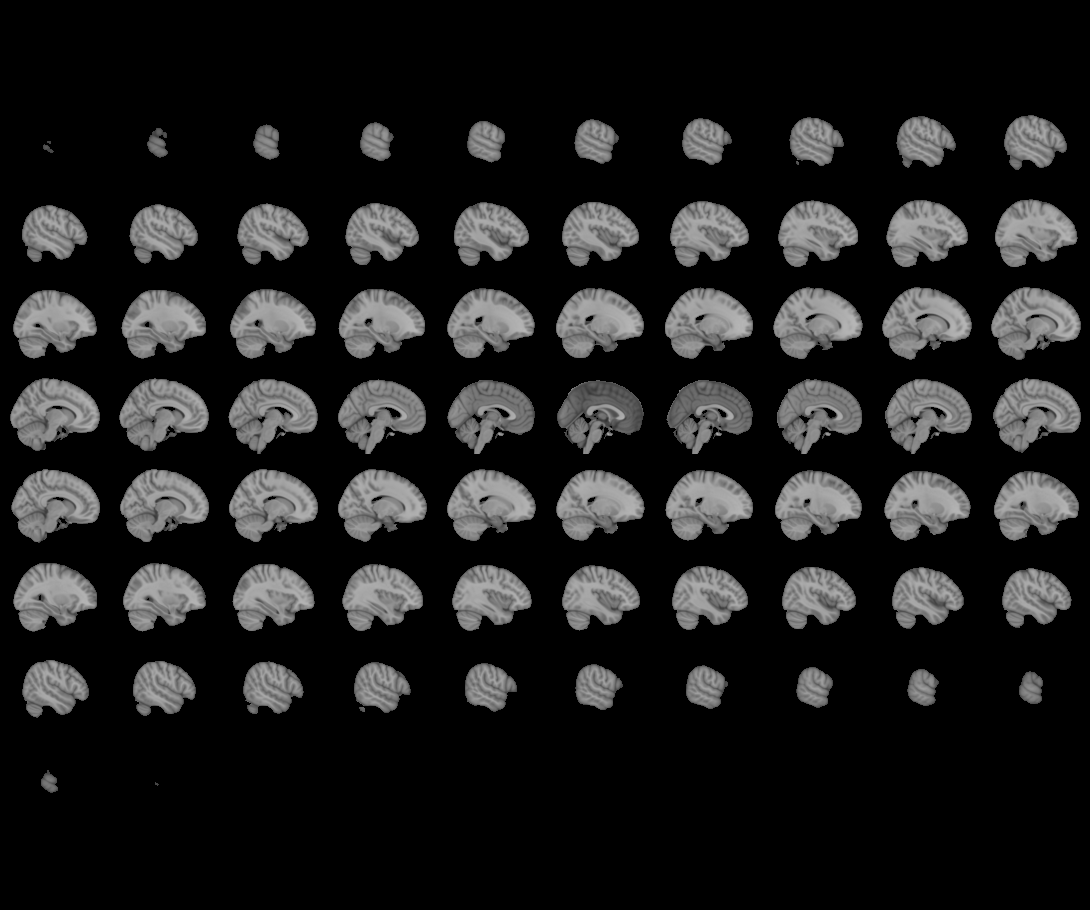
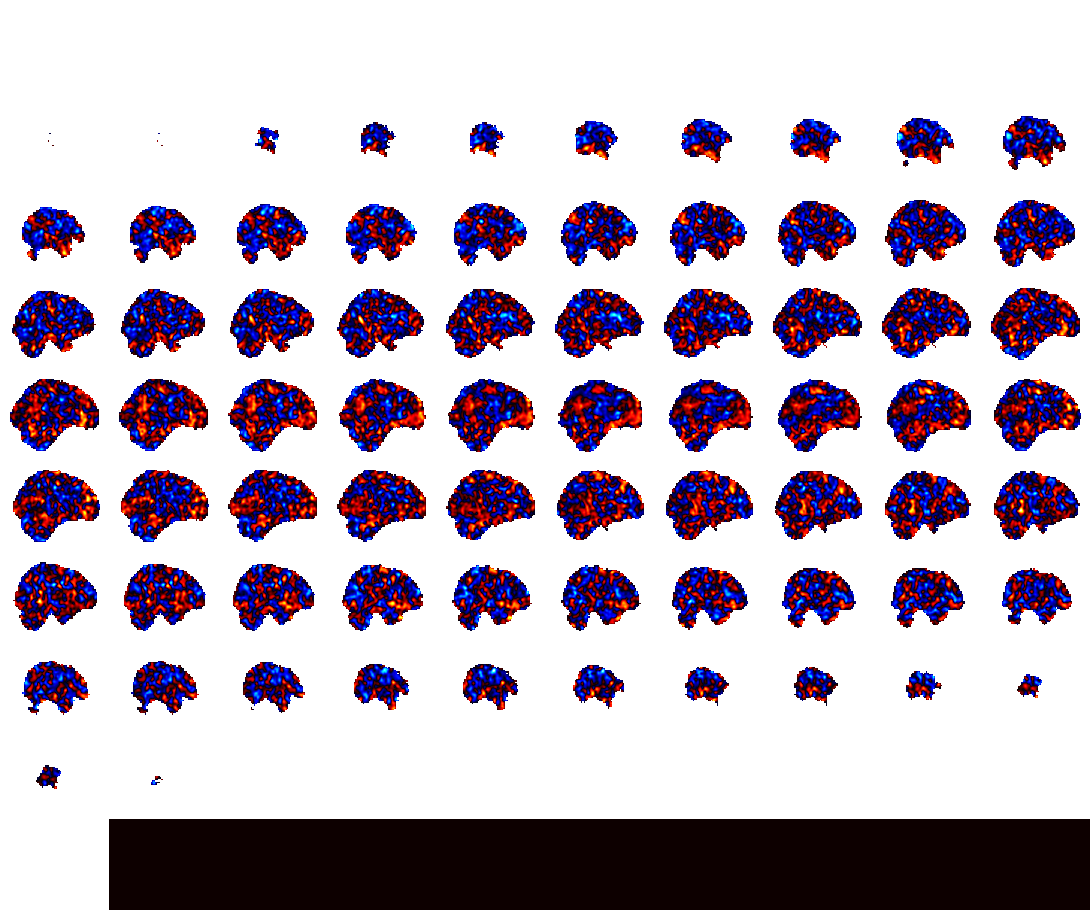

In [12]:
num_s = 0 # the subject number
num_t = 50 # the frame number
img = model.load_img(epi_filename[num_s])
plotting.view_img(image.index_img(img, [num_t]), vmax=4)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(61, 73, 61, 176),
affine=array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals



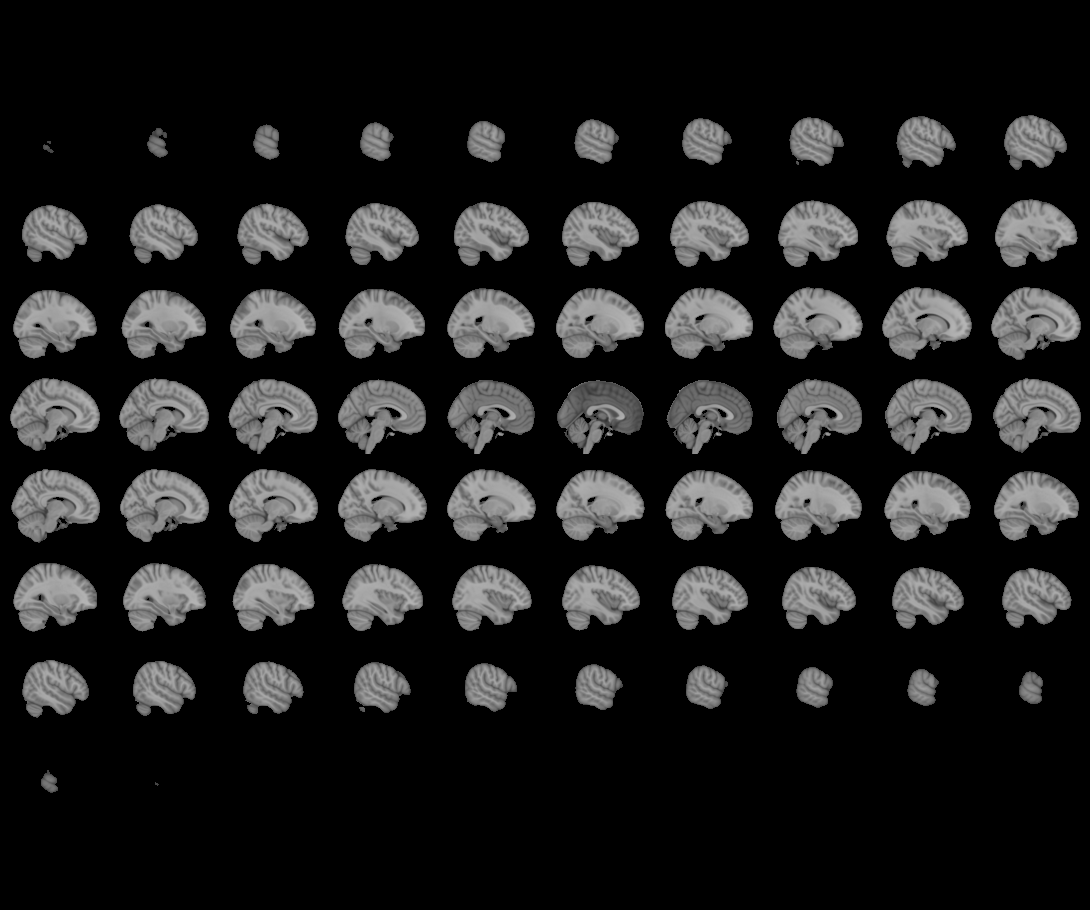
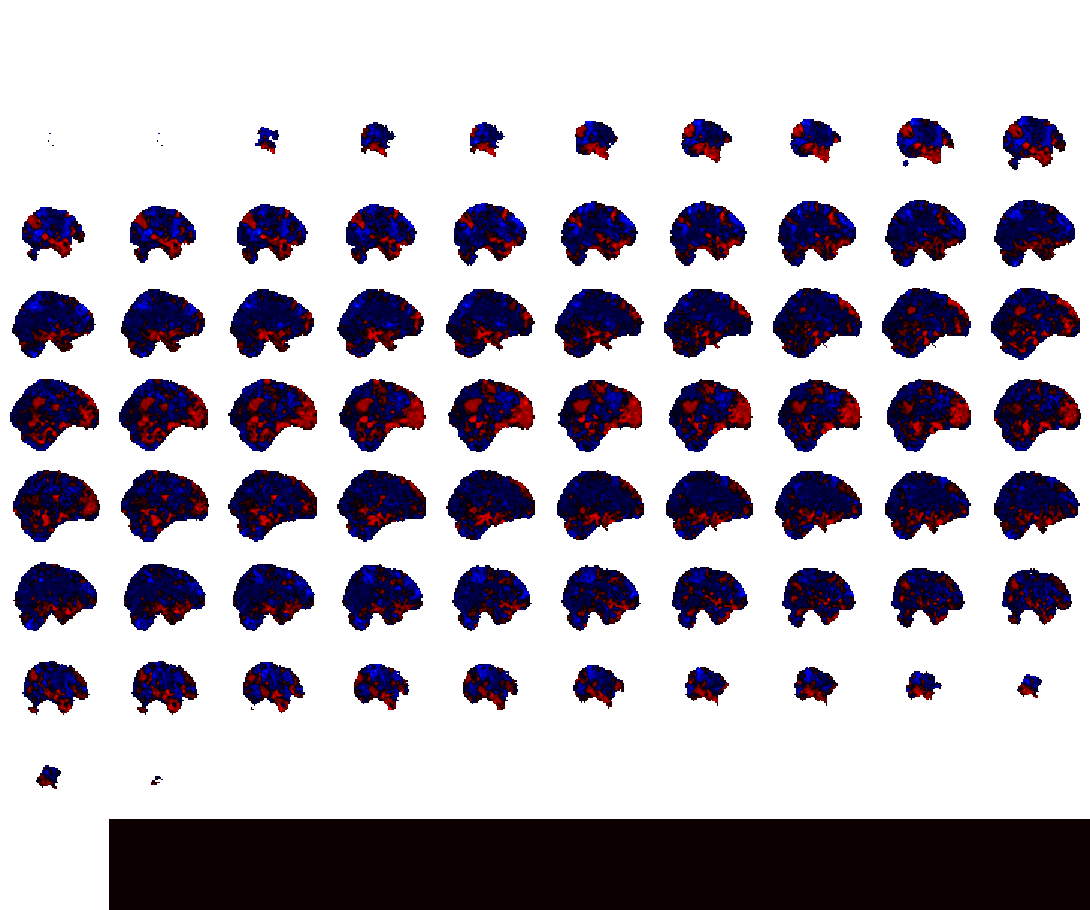

In [13]:
img_r = model.compress(img)
plotting.view_img(image.index_img(img_r, [num_t]), vmax=4)

[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(61, 73, 61, 176),
affine=array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals



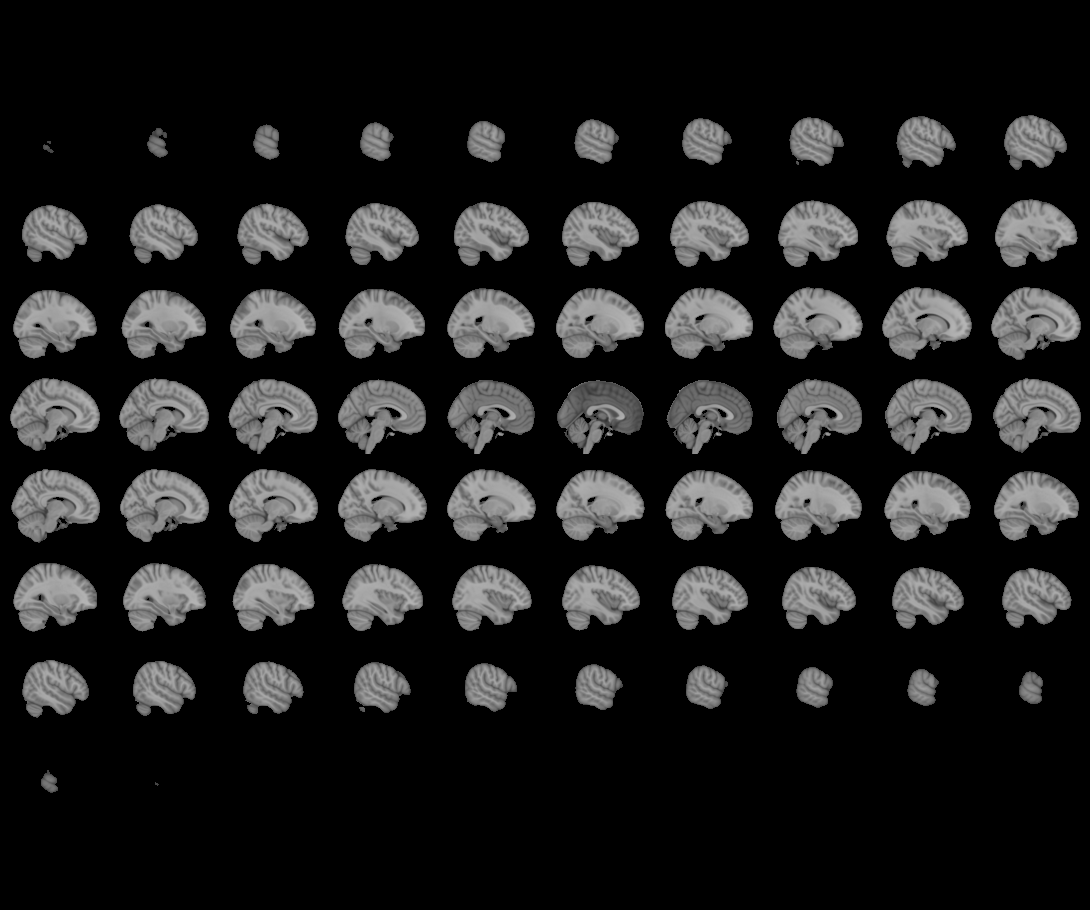
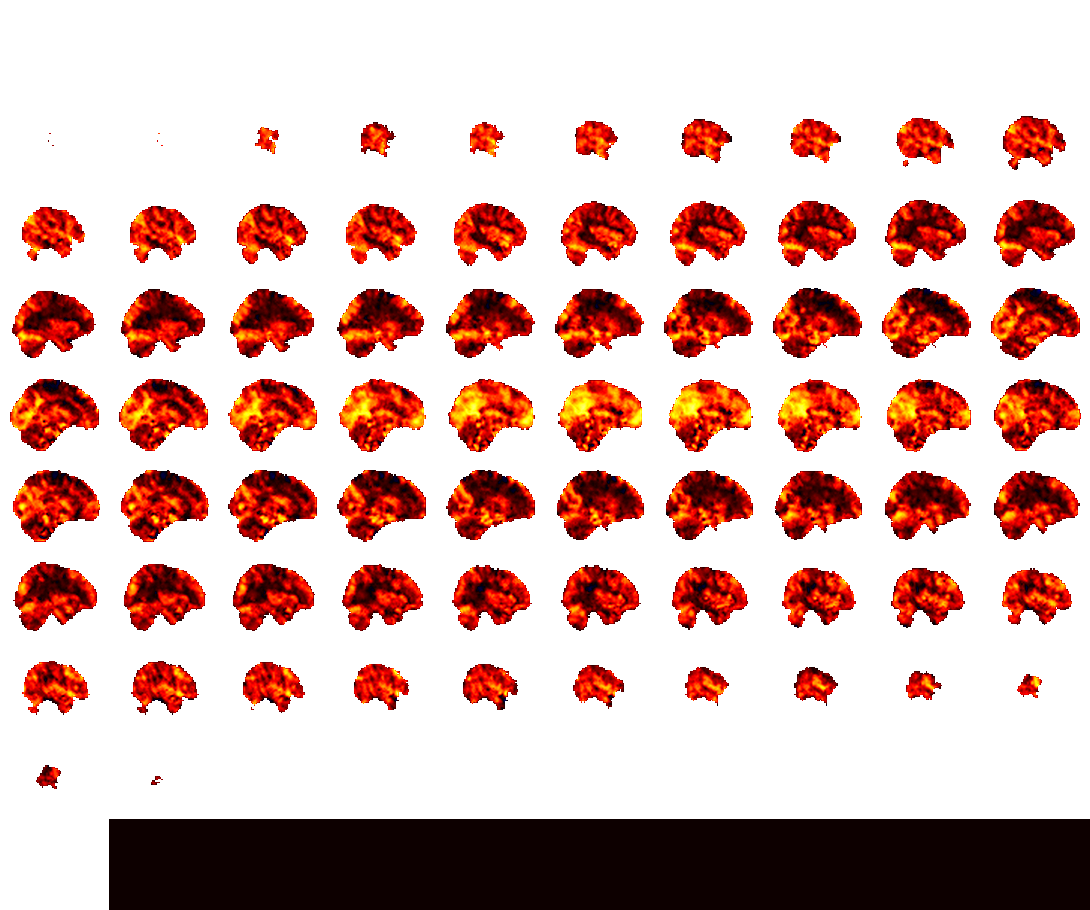

In [14]:
score = model.score(img)
plotting.view_img(score, vmax=1)